# <font color='#42AAFF'>Содержание</font><a id='toc0_'></a>  <a id='toc0_'></a>    
1. [<font color='#42AAFF'>Импорт предобработанных данных</font>](#toc1_)    
2. [<font color='#42AAFF'>Проверка признаков на мультиколлинеарность</font>](#toc2_)    
3. [<font color='#42AAFF'>Оптимизация FAISS</font>](#toc3_)    
3.1. [<font color='#42AAFF'>Обучение индексов при разном количестве кластеров</font>](#toc3_1_)    
3.2. [<font color='#42AAFF'>Исследование влияния гиперпараметров</font>](#toc3_2_)    
4. [<font color='#42AAFF'>Финальный вариант FAISS для train</font>](#toc4_)    
5. [<font color='#42AAFF'>Вариант 1 FAISS для test</font>](#toc5_)    
6. [<font color='#42AAFF'>Вариант 2 FAISS для test</font>](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import faiss
import time
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import colorcet as cc

# 1. <a id='toc1_'></a>[<font color='#42AAFF'>Импорт предобработанных данных</font>](#toc0_)

In [2]:
features_base = pd.read_csv('features_base.csv',index_col=0)
features_train = pd.read_csv('features_train.csv',index_col=0)
features_test = pd.read_csv('features_test.csv',index_col=0)
target_train = pd.read_csv('target_train.csv',index_col=0)
target_test = pd.read_csv('target_test.csv',index_col=0)

Колонки с признаками, имеющими явно не стандартные распределения:

In [3]:
cols1 = ['6', '21', '25', '33', '44', '59', '65', '70']

# 2. <a id='toc2_'></a>[<font color='#42AAFF'>Проверка признаков на мультиколлинеарность</font>](#toc0_)

Проверим исходную базу на коллинеарность признаков с помощью Variance Inflation Factor:

In [4]:
def variance_inflation_factors(x):
    model = LinearRegression()
    vif = pd.DataFrame(columns=['features','vif'])
    for i in range(x.shape[1]):        
        x_i = x.drop(x.columns[i], axis=1)
        y_i = x[x.columns[i]]
        model_i = model.fit(x_i, y_i)
        y_i_pred = model_i.predict(x_i)        
        r2_i = r2_score(y_i, y_i_pred)        
        vif_i = 1 / (1 - r2_i)
        vif.loc[i,'features'] = x.columns[i]
        vif.loc[i,'vif'] = vif_i
        vif = vif.sort_values(by='vif',ascending=False).reset_index(drop=True)
    return vif

Если VIF>5 то будем считать признак коллинеарным, определим VIF:

In [5]:
variance_inflation_factors(features_base)

,features,vif
0,63,1.229038
1,35,1.147099
2,57,1.102206
3,10,1.093029
4,45,1.0893
...,...,...
67,6,1.019902
68,18,1.019497
69,12,1.017122
70,65,1.00188


Мультиколлинеарных признаков не обнаружили.

# 3. <a id='toc3_'></a>[<font color='#42AAFF'>Оптимизация FAISS</font>](#toc0_)

## 3.1. <a id='toc3_1_'></a>[<font color='#42AAFF'>Обучение индексов при разном количестве кластеров</font>](#toc0_)

In [ ]:
num, dim = features_base.shape
quantiser = faiss.IndexFlatL2(dim) 
n_clusters_list = [15, 30, 50, 100, 250, 500, 1000, 2000, 3000]

Обучим индексы при разном количестве кластеров и сохраним результаты:

In [ ]:
%%time
for j,n_clusters in enumerate(n_clusters_list):
    index = faiss.IndexIVFFlat(quantiser, dim, n_clusters)
    index.train(np.ascontiguousarray(features_base.values).astype('float32'))
    index.add(np.ascontiguousarray(features_base.values).astype('float32'))
    faiss.write_index(index, 'index_'+ str(n_clusters))

Wall time: 40min 18s


## 3.2. <a id='toc3_2_'></a>[<font color='#42AAFF'>Исследование влияния гиперпараметров</font>](#toc0_)

In [2]:
def faiss_accuracy(features_base,base_index,features_train,target_train,n_clusters_search,n_samples,index):    
    start_time = time.time()    
    index.nprobe = n_clusters_search
    vecs, idx = index.search(np.ascontiguousarray(features_train.values).astype('float32'), n_samples)
    t_search = time.time() - start_time
    acc = 0
    for target, el in zip(target_train[target_train.columns[0]].values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    acc = 100 * acc / len(idx) 
    return acc, t_search  

In [ ]:
results = pd.DataFrame(columns=['n_clusters','n_clusters_search','n_clusters_ratio','n_samples','time_search','accuracy'])
n_clusters_list = [15, 100, 250, 500, 1000, 2000, 3000]
n_clusters_ratio = [0.1, 0.2, 0.5]
n_samples_list = [5, 200, 500]

ind=0;
for n_clusters in n_clusters_list:
    index = faiss.read_index('index_'+ str(n_clusters))
    base_index = {k: v for k, v in enumerate(features_base.index.to_list())}
    for ratio in n_clusters_ratio:
        n_clusters_search = int(np.ceil(ratio*n_clusters))
        for n_samples in n_samples_list:
            acc, t_search  = faiss_accuracy(
                features_base, base_index,features_train,target_train,n_clusters_search,n_samples,index)            
            results.loc[ind,'n_clusters'] = n_clusters
            results.loc[ind,'n_clusters_search'] = n_clusters_search
            results.loc[ind,'n_clusters_ratio'] = ratio
            results.loc[ind,'n_samples'] = n_samples            
            results.loc[ind,'accuracy'] = acc
            results.loc[ind,'time_search'] = t_search  
            display(results[ind:ind+1])    
            ind += 1 

In [11]:
#results.to_csv('results.csv')
results = pd.read_csv('results.csv',index_col=0)

In [12]:
results.head(5)

,n_clusters,n_clusters_search,n_clusters_ratio,n_samples,time_search,accuracy
0,15,2,0.1,5,425.775919,54.554
1,15,2,0.1,200,429.399675,65.486
2,15,2,0.1,500,424.060921,67.148
3,15,3,0.2,5,630.815978,58.191
4,15,3,0.2,200,631.957546,70.751


Построим графики для результатов оптимизации FAISS по метрике accuracy - в данном случае доля правильных ответов в выборке кандидатов объемом n_samples:
1. При объеме выборки 5, 200, 500 удалось достичь accuracy не более 64%, 83%, 84%. Таким образом, при увеличении n_samples метрика насыщается и при изменении от n_samples 200 до 500 практически не растёт. Вероятно наибольший интерес представляет значение n_samples до 50-100, что также существенно облегчит работу классификатора в будущем.
2. При доле кластеров поиска 0.1 от общего числа кластеров метрика насыщается уже при 500-1000 кластерах и дальнейшее их увеличение не приводит к увеличению accuracy. При бОльших значениях отношения кластеров поиска к общему числу кластеров насыщение происходит еще раньше.
3. Увеличение доли кластеров к общему их числу позволяет увеличить установившуюся метрику на единицы %, при этом время поиска линейно растёт от отношения кол-ва кластеров поиска к общему их числу, и слабо зависит от других параметров.

Таким образом, наибольший интерес представляет область параметров: n_samples = 50, n_clusters = 1000, n_clusters_ratio= 0.1-1 (в зависимости от ресурсов)

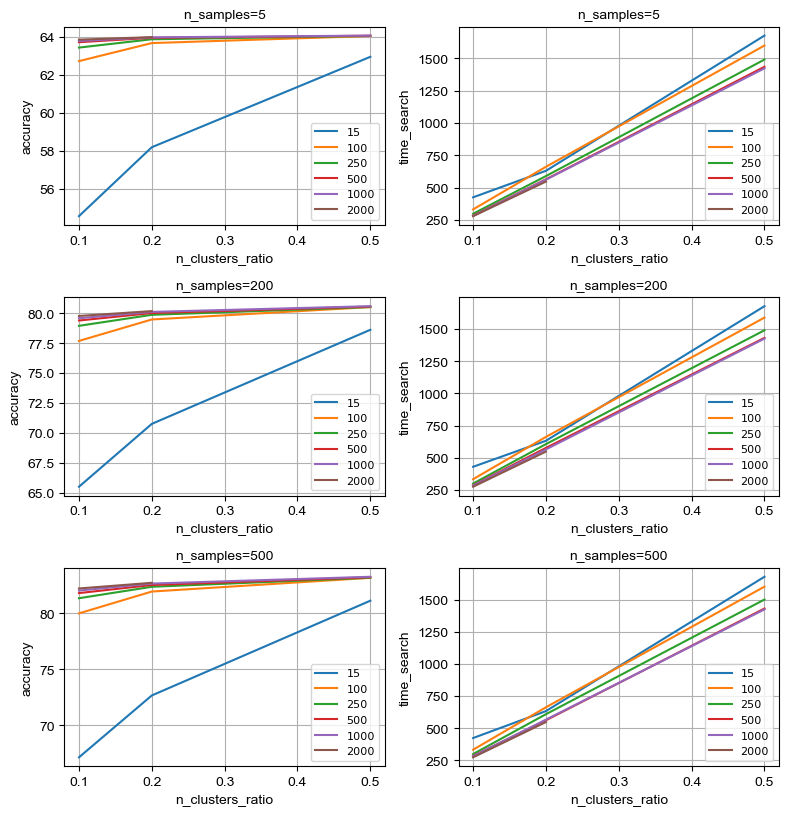

In [84]:
cm = 1/2.54
cmap = plt.cm.get_cmap('tab10')
fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(20*cm,21*cm),dpi=100)

for row,n_samples in enumerate(results['n_samples'].unique()):
    sns.lineplot(
        data=results.query('n_samples==@n_samples'),
        x='n_clusters_ratio',
        y='accuracy',
        hue='n_clusters',       
        palette=sns.color_palette('tab10', n_colors=6),        
        ax=axs[row,0])
    axs[row,0].grid(True)
    axs[row,0].set_title(f'n_samples={n_samples}')
    sns.lineplot(
        data=results.query('n_samples==@n_samples'),
        x='n_clusters_ratio',
        y='time_search',
        hue='n_clusters',       
        palette=sns.color_palette('tab10', n_colors=6),        
        ax=axs[row,1])
    axs[row,1].grid(True)
    axs[row,1].set_title(f'n_samples={n_samples}')  

for ax in axs.flatten():
      ax.legend(fontsize=8,loc=4)
      for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font('Arial')
        item.set_fontsize(10)
        
fig.tight_layout()
plt.show() 

# 4. <a id='toc4_'></a>[<font color='#42AAFF'>Финальный вариант FAISS для train</font>](#toc0_)

In [3]:
%%time
n_clusters = 1000
ratio = 0.1
n_samples = 50

index = faiss.read_index('index_'+ str(n_clusters))
base_index = {k: v for k, v in enumerate(features_base.index.to_list())}
n_clusters_search = int(np.ceil(ratio*n_clusters))
start_time = time.time()    
index.nprobe = n_clusters_search
vecs, idx = index.search(np.ascontiguousarray(features_train.values).astype('float32'), n_samples)
acc = 0
for target, el in zip(target_train[target_train.columns[0]].values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
acc = 100 * acc / len(idx) 
print(acc)                        

74.961
Wall time: 5min 5s


In [11]:
pd.DataFrame(idx).to_csv('index_train.csv')
pd.DataFrame(vecs).to_csv('vecs_train.csv')
pd.DataFrame.from_dict(base_index,orient='index').to_csv('base_index_train.csv')

# 5. <a id='toc5_'></a>[<font color='#42AAFF'>Вариант 1 FAISS для test</font>](#toc0_)

In [ ]:
%%time
n_clusters = 1000
ratio = 0.1
n_samples = 50

index = faiss.read_index('index_'+ str(n_clusters))
base_index = {k: v for k, v in enumerate(features_base.index.to_list())}
n_clusters_search = int(np.ceil(ratio*n_clusters))
start_time = time.time()    
index.nprobe = n_clusters_search
vecs, idx = index.search(np.ascontiguousarray(features_test.values).astype('float32'), n_samples)
acc = 0
for target, el in zip(target_test[target_test.columns[0]].values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
acc = 100 * acc / len(idx) 
print(acc)   

In [ ]:
pd.DataFrame(idx).to_csv('index_test1.csv')
pd.DataFrame(vecs).to_csv('vecs_test1.csv')
pd.DataFrame.from_dict(base_index,orient='index').to_csv('base_index_test1.csv')

# 6. <a id='toc6_'></a>[<font color='#42AAFF'>Вариант 2 FAISS для test</font>](#toc0_)

In [ ]:
%%time
n_clusters = 20
ratio = 0.5
n_samples = 500

index = faiss.IndexIVFFlat(quantiser, dim, n_clusters)
index.train(np.ascontiguousarray(features_base.values).astype('float32'))
index.add(np.ascontiguousarray(features_base.values).astype('float32'))
faiss.write_index(index, 'index_'+ str(n_clusters))

index = faiss.read_index('index_'+ str(n_clusters))
base_index = {k: v for k, v in enumerate(features_base.index.to_list())}
n_clusters_search = int(np.ceil(ratio*n_clusters))
start_time = time.time()    
index.nprobe = n_clusters_search
vecs, idx = index.search(np.ascontiguousarray(features_test.values).astype('float32'), n_samples)
acc = 0
for target, el in zip(target_test[target_test.columns[0]].values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
acc = 100 * acc / len(idx) 
print(acc)   

In [ ]:
pd.DataFrame(idx).to_csv('index_test.csv')
pd.DataFrame(vecs).to_csv('vecs_test.csv')

In [ ]:
pd.DataFrame(idx).to_csv('index_test2.csv')
pd.DataFrame(vecs).to_csv('vecs_test2.csv')
pd.DataFrame.from_dict(base_index,orient='index').to_csv('base_index_test2.csv')